In [10]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


                                              0.0/11.3 MB ? eta -:--:--
                                              0.0/11.3 MB ? eta -:--:--
                                             0.1/11.3 MB 656.4 kB/s eta 0:00:18
                                             0.1/11.3 MB 563.7 kB/s eta 0:00:20
                                             0.1/11.3 MB 722.1 kB/s eta 0:00:16
                                             0.2/11.3 MB 766.6 kB/s eta 0:00:15
                                             0.2/11.3 MB 831.5 kB/s eta 0:00:14
                                             0.2/11.3 MB 801.7 kB/s eta 0:00:14
                                             0.3/11.3 MB 780.5 kB/s eta 0:00:15
     -                                       0.3/11.3 MB 819.2 kB/s eta 0:00:14
     -                                       0.4/11.3 MB 882.8 kB/s eta 0:00:13
     -                                       0.4/11.3 MB 882.8 kB/s eta 0:00:13
     -                                       0.4/11.3 MB


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from svetlanna.clerk import Clerk
import matplotlib.pyplot as plt
import torch

Рассмотрим модель нейронной сети с методом `forward`, который определяется выражением $f(x) = a^2$, где $a$ - параметр модели.

In [12]:
class MyNet(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.a = torch.nn.Parameter(torch.tensor(10.))

    def forward(self, *args, **kwargs):
        return self.a**2

Теперь познакомимся с модулем Cleck, который помогает логировать данные.
Cleck позволяет пользователям управлять экспериментами, каждый из которых представляет собой определённый цикл обучения модели при определённых условиях, таких как особые гиперпараметры.

In [13]:
clerk = Clerk('experiment_example')

Данные будут сохранены в папку `experiment_example`.
Для регистрации условий эксперимента используйте метод `save_conditions`.
Условиями могут быть любые данные, которые можно сериализовать в JSON.

In [14]:
conditions = {
    'date': '23/01',
    'description': 'Example model',
    'some_parameters': [1., 123, '1']
}
clerk.save_conditions(conditions)

Приступим к эксперименту с обучений созданной модели.
Для начала нам нужно создать оптимизатор и инициализировать модель:

In [15]:
model = MyNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

Во время обучения мы можем создавать контрольные точки, хранящие все параметры модели и оптимизатора. Это позволяет перезагружать их позже для возобновления или перезапуска эксперимента.
Чтобы указать, какие объекты с `state_dict` следует сохранять в контрольных точках, мы используем метод `set_checkpoint_targets`.
Каждый объект должен иметь уникальный ключ, который будет использоваться для восстановления определённых параметров при необходимости:

In [16]:
clerk.set_checkpoint_targets({
    'model': model,
    'optimizer': optimizer
})

В качестве модели можно использовать объект `LinearOpticalSetup`.

Теперь мы готовы начать процесс обучения.
Две наиболее распространённые операции во время обучения — это регистрация потерь и создание контрольных точек.
Ниже продемонстрированы оба сценария.

In [17]:
with clerk:  # Enable Clerk's writing mode
    for epoch in range(10):
        for batch in range(20):
            # Standard training procedure
            loss = model()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Log training data with a specific tag
            # Data must be JSON serializable
            clerk.write_log(
                'loss_log',  # Tag for the log entry
                {
                    'loss': loss.item(),  # the data
                    'x': model.a.item(),
                    'batch': batch,
                    'epoch': epoch
                }
            )

        # Create a new checkpoint at the end of each epoch.
        # Metadata can be included to describe the checkpoint.
        clerk.write_checkpoint(metadata={'epoch': epoch})

Мы можем получить доступ к логированным данным, используя `pandas`, после чего визуализировать кривую потерь:

**<span style="color:red">ВАЖНО:</span>** поскольку данный функционал является опциональным, необходимо перед запуском установить библиотеку [pandas](https://pandas.pydata.org/)

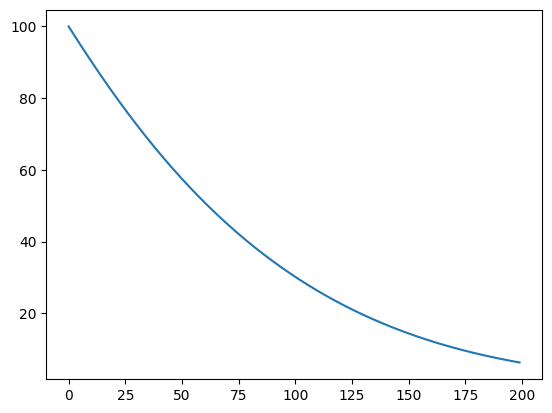

In [18]:
df = clerk.load_logs_to_pandas(tag='loss_log')
plt.plot(df['loss'])

Если необходимо продолжить процесс обучения, можно использовать функцию возобновления клерка.
Это делается путем настройки клерка с помощью `begin(resume=True)`.
При возобновлении параметры объектов, ранее заданные с помощью `set_checkpoint_targets`, будут восстановлены из контрольной точки с наибольшим индексом.

In [19]:
with clerk.begin(resume=True):  # Enable Clerk's writing mode and resume from the latest checkpoint
    for epoch in range(10):
        for batch in range(20):

            loss = model()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            clerk.write_log(
                'loss_log',
                {
                    'loss': loss.item(),
                    'x': model.a.item(),
                    'batch': batch,
                    'epoch': epoch
                }
            )

        clerk.write_checkpoint(metadata={'epoch': epoch})

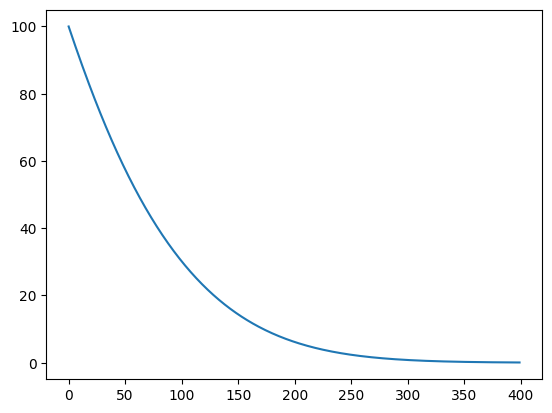

In [20]:
df = clerk.load_logs_to_pandas(tag='loss_log')
plt.plot(df['loss'])

Можно заметить, что обучение продолжалось ещё 200 шагов.

Ещё одна особенность клерка заключается в том, что во время вывода можно загрузить определённую контрольную точку и использовать сохранённые параметры модели для прогнозирования.

In [21]:
# инициализация модели
model_inference = MyNet()

# Создание нового экземпляра Clerk для вывода
clerk = Clerk('experiment_example')

# Загрузка условий эксперимента
conditions = clerk.load_conditions()

# Загрузка контрольной точки с индексом 9
# Здесь мы указываем, что хотим загрузить модель и оптимизатор из контрольной точки
# Параметры, указанные в set_checkpoint_targets, будут восстановлены из контрольной точки
# Если вы хотите загрузить другие объекты, их также нужно указать в set_checkpoint_targets
metadata = clerk.load_checkpoint(9, targets={
    'model': model_inference
})

# Теперь модель готова к использованию
print('conditions', conditions)
print('metadata:', metadata)

conditions {'date': '23/01', 'description': 'Example model', 'some_parameters': [1.0, 123, '1']}
metadata: {'epoch': 9}


Clerk предоставляет функцию автоматического резервного копирования, гарантируя сохранение состояния обучения в случае возникновения исключения внутри контекста.
Чтобы включить эту функцию, установите флаг autosave_checkpoint в значение True:

In [24]:
try:
    with clerk.begin(autosave_checkpoint=True):
        for epoch in range(10):
            for batch in range(20):
                # Simulating an error
                raise RuntimeError
except:
    pass

Как показано выше, контрольные точки можно загрузить, используя их индекс.
Вы также можете загрузить контрольную точку, указав имя её файла напрямую:

In [ ]:
backup_file = next(
    (f.name for f in clerk.experiment_directory.iterdir() if f.is_file() and f.name.startswith('backup_')),
    None
)
backup_file

In [ ]:
metadata = clerk.load_checkpoint(
    backup_file  # Используйте имя выбранной контрольной точки
)

print('metadata:', metadata)

Чтобы удалить все резервные контрольные точки, используйте:

In [26]:
clerk.clean_backup_checkpoints()